# Coverage Vector

In [51]:
import itertools
import time
import os
import sys

In [52]:
import numpy as np

In [53]:
import HTSeq

In [54]:
def invert_strand(iv):
    
    iv2 = iv.copy()
    
    if iv2.strand == "+":
        iv2.strand = "-"
        
    elif iv2.strand == "-":
        iv2.strand = "+"
        
    else:
        raise ValueError("Illegal strand")
        
    return iv2

In [55]:
# CIGAR match characters (including alignment match, sequence match, and sequence mismatch)
com = ('M', '=', 'X')

In [56]:
## heterochromatic genes
htc_genes = ('dg1', 'dh1', 'after_tlh', 'MAT2', 'MAT3', 'MAT1')

- Select `sample` **dataset**:

In [65]:
#sample_name = '1113_pA'
#sample_name = '1168_pA'
#sample_name = '1022_INPUT'
sample_name = '524_1_S2ChIP'

In [66]:
data_batch = 'sequencing_new'
#data_batch = ''

In [67]:
seq_type = 'ChIP'
#seq_type = 'RNA'

- Select `gtf` **file**: instantiate `GFF_Reader` **object**

In [68]:
# select gtf file: instantiate GFF_Reader Object
gtf_file = HTSeq.GFF_Reader("/gcm-lfs1/pablo/data/RNAdeg/annotation/gff/schizosaccharomyces_pombe.chr.extended.gff3")

In [69]:
htc_genes_dict = {}

## loop over all features in gtf file
for feature in gtf_file:
    
    ## store all exons in our `GenomicArrayOfSets`
    if feature.type == "exon":
        
        ## identify each `exon` feature by parent transcript/gene
        gene_id = feature.attr["Parent"].split(':')[1][:-2] ## get rid of '.1'
        
        if gene_id in htc_genes:

            # Is this the first time we see this gene?
            if gene_id not in htc_genes_dict:
                # If so, add to the 'genes_dict' an empty list 
                htc_genes_dict[ gene_id ] = list()

            # add the feature to the gene list
            htc_genes_dict[ gene_id ].append( feature )

In [70]:
htc_genes_dict

{'dg1': [<GenomicFeature: exon 'dg1.1:exon:1' at I: 3764499 -> 3760998 (strand '-')>],
 'dh1': [<GenomicFeature: exon 'gene:dh1.1:exon:1' at I: 3756999 -> 3752998 (strand '-')>],
 'after_tlh': [<GenomicFeature: exon 'after_tlh.1:exon:1' at II: 4538999 -> 4533998 (strand '-')>],
 'MAT2': [<GenomicFeature: exon 'MAT2.1:exon:1' at II: 2132999 -> 2128998 (strand '-')>],
 'MAT3': [<GenomicFeature: exon 'MAT3.1:exon:1' at II: 2136999 -> 2132998 (strand '-')>],
 'MAT1': [<GenomicFeature: exon 'MAT1.1:exon:1' at II: 2115499 -> 2113998 (strand '-')>]}

- Parse `BAM` **File** to get **mapped reads**

In [71]:
# select bam file:
#bam_file_path = os.path.join('/gcm-lfs1/pablo/data/RNAdeg/data', data_batch, seq_type, 'bams', sample_name, sample_name + '.Aligned.sortedByCoord.out.bam')
bam_file_path = os.path.join('/gcm-lfs1/pablo/data/RNAdeg/data', data_batch, seq_type, 'bam', sample_name, sample_name + '.Aligned.sortedByCoord.out.bam')
bam_file_path

'/gcm-lfs1/pablo/data/RNAdeg/data/sequencing_new/ChIP/bam/524_1_S2ChIP/524_1_S2ChIP.Aligned.sortedByCoord.out.bam'

In [72]:
import collections
counts = collections.Counter( )

# select bam file: instantiate BAM_Reader Object (RNA-seq)
#bam_file = HTSeq.BAM_Reader(os.path.join('/gcm-lfs1/pablo/data/RNAdeg/data/RNA/bams', sample_name, sample_name + '.Aligned.sortedByCoord.out.bam'))
#bam_file = HTSeq.BAM_Reader(os.path.join('/gcm-lfs1/pablo/data/RNAdeg/data/sequencing_new/ChIP/bam', sample_name, sample_name + '.Aligned.sortedByCoord.out.bam'))
bam_file = HTSeq.BAM_Reader(bam_file_path)

start_time = time.time()

## -------
## Options
## -------

i = 0

for aln in itertools.islice(bam_file, 10):
#for aln in bam_file:

    if i > 0 and i % 100000 == 0:
        sys.stderr.write("{} alignment records processed. {} s\n".format(i,  time.time() - start_time))
        sys.stderr.flush()
    i += 1          
    
    ## ----------------------
    ## Inspect read alignment
    ## ----------------------
    
    ## _mapped or _unmapped (our BAM files only contain _mapped)
    counts["_total"] += 1
    
    if not aln.aligned:
        
        import pdb
        pdb.set_trace()
        
        counts["_unmapped"] += 1
        ## skips to next iteration
        continue
         
    ## invert strand - due to sequencing is strand is reversed!
    iv_seq = (invert_strand(co.ref_iv) for co in aln.cigar if (co.type in com and co.size > 0))
    #iv_seq = (co.ref_iv for co in aln.cigar if (co.type in com and co.size > 0))

    
print('Elapsed Time (Counting reads):', time.time() - start_time)

Elapsed Time (Counting reads): 0.0045278072357177734


## Genomic intervals and genomic arrays

### Genomic intervals

At the end of the previous section, we looped through a `SAM` file. In the for loop, the `SAM_Reader` **object** yields for each **alignment line** in the SAM file **an object** of class `SAM_Alignment`. 

Let’s have closer look at such an object, still found in the variable `aln`:

In [73]:
aln

<SAM_Alignment object: Read 'L183:528:CDNP6ANXX:6:2108:7429:98858' aligned to chr_II_telomeric_gap:[16,66)/+>

Every `SAM_Alignment` **object** has a slot `read`, that contains a `SequenceWithQualities` **object** as described above:

In [74]:
aln.read

<SequenceWithQualities object 'L183:528:CDNP6ANXX:6:2108:7429:98858'>

an **object** of class `SequenceWithQualities` has corresponding **attributes**:
- `name`
- `seq`
- `qualstr`
- `qual`

In [75]:
## name
aln.read.name

'L183:528:CDNP6ANXX:6:2108:7429:98858'

In [76]:
## base pairs sequence
aln.read.seq

b'TGGTATAATAACATGATATTGTTAAAAGAAAAGTTGAAGTATGCAGCTAG'

In [77]:
## quality string??
aln.read.qualstr

b'CCCCCGGGGGGGEEGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG'

In [78]:
## base pairs sequencing quality
aln.read.qual

array([34, 34, 34, 34, 34, 38, 38, 38, 38, 38, 38, 38, 36, 36, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38],
      dtype=uint8)

Furthermore, every `SAM_Alignment` **object** has a slot `iv` (for **“interval”**), that contains a `GenomicInterval` **object** used to describe where the read was aligned to (if it was aligned).

In [79]:
aln.iv

<GenomicInterval object 'chr_II_telomeric_gap', [16,66), strand '+'>

an **object** of class `GenomicInterval` has corresponding **attributes**:
- `chrom`
- `start`
- `end`
- `strand`

In [80]:
## chromosome
aln.iv.chrom

'chr_II_telomeric_gap'

In [81]:
## start read
aln.iv.start

16

In [82]:
## end read
aln.iv.end

66

In [83]:
## DNA strand
aln.iv.strand

'+'

Note that all coordinates in *HTSeq* are **zero-based** (following Python convention), i.e. the first base of a chromosome has index 0. Also, all intervals are half-open, i.e., the `end` position is not included. The strand can be one of `'+'`, `'-'`, or `'.'`, where the latter indicates that the strand is not defined or not of interest.

Apart from these slots, a [GenomicInterval](https://htseq.readthedocs.io/en/release_0.11.1/genomic.html#HTSeq.GenomicInterval) **object** has a number of convenience functions, see the reference.

Note that a `SAM` file may contain reads that **could not be aligned**. For these, the `iv` slot contains `None`. To test whether an alignment is present, you can also query the slot `aligned`, which is a `Boolean`:

In [84]:
## check wether the current read map was aligned or not
aln.aligned

True

### Genomic Arrays

The `GenomicArray` **data structure** is a convenient way to store and retrieve information associated with a **genomic position** or **genomic interval**. In a `GenomicArray`, data (simple scalar data like a number) can be stored at a place identified by a `GenomicInterval`. We demonstrate with a toy example.

Assume you have a genome with **three chromosomes** with the following lengths (in `bp`):

In [85]:
chrom_lens = {'chr1':3000, 'chr2':2000, 'chr1':1000}
chrom_lens

{'chr1': 1000, 'chr2': 2000}

We wish to store **integer data** (typecode: `"i"`) in a **genomic array** (`ga`):

In [86]:
# GenomicArray: chromosome lengths, strandedness, type of data
ga = HTSeq.GenomicArray(chrom_lens, stranded=False, typecode="i" )
ga

Now, we can **assign** (`=`) the value 5 to a **genomic interval** (`iv`): 

In [87]:
# GenomicInterval: chromosome, start, end, strand
iv_1 = HTSeq.GenomicInterval("chr1", 100, 120, ".")
ga[ iv_1 ] = 5

We may want to **add** (`+=`) the value 3 to a **genomic interval** (`iv`) overlapping with the previous one:

In [102]:
# GenomicInterval: chromosome, start, end, strand
iv_2 = HTSeq.GenomicInterval("chr1", 110, 135, ".")
ga[ iv_2 ] += -10

To see the effect of this, we can **read out** a yet another **genomic interval** encompassing the region that we changed.

In [89]:
# GenomicInterval: chromosome, start, end, strand
iv = HTSeq.GenomicInterval("chr1", 90, 140, "." )

To **display** the data, we convert to a **list**:

In [103]:
print(list(ga[ iv ]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, 0, 0, 0, 0, 0]


It would be wasteful to store all these repeats of the same value as it is displayed here. Hence, `GenomicArray` objects use by default so-called `StepVectors` that store the data internally in **“steps” of constant value**. Often, reading out the data that way is useful, too:

In [91]:
ga[ iv ].steps()

<generator object ChromVector_steps at 0x7fc1663cec50>

In [92]:
for _iv, _value in ga[ iv ].steps():
    print(_iv, _value)

chr1:[90,100)/. 0
chr1:[100,110)/. 5
chr1:[110,120)/. 8
chr1:[120,135)/. 3
chr1:[135,140)/. 0


If the steps become very small, storing them instead of just the unrolled data may become inefficient. In this case, `GenomicArrays` should be instantiated with **storage mode** `ndarray` to get a normal **numpy array** as backend, or with **storage mode** `memmap` to use a **file/memory-mapped numpy array** (see reference for details).

In the following section, we demonstrate how a `GenomicArray` can be used to calculate a **coverage vector**. In the section after that, we see how a `GenomicArray` with **type code** `‘O’` (which stands for ‘object’, i.e., any kind of data, not just numbers) is useful to organize metadata.

## Calculating coverage vectors

By a “**coverage vector**”, we mean a vector (one-dimensional array) of the length of a chromosome, where **each element counts how many reads cover the corresponding base pair in their alignment**. A `GenomicArray` can conveniently bundle the coverage vectors for all the chromosomes in a genome.

Hence, we start by defining a `GenomicArray` for the coverage(`cvg`):

In [35]:
cvg = HTSeq.GenomicArray("auto", stranded=True, typecode="i")

Instead of listing all chromosomes, we instruct the `GenomicArray` to **add chromosome vectors** as needed, by specifiyng `"auto"`. As we set `stranded=True`, there are now **two chromosome vectors for each chromosome**, all holding **integer values** (`typecode="i"`). They all have an “infinte” length as we did not specify the actual lengths of the chromosomes.

To build the **coverage vectors**, we now simply **iterate through all the reads** and add the **value** `1` at the interval to which each read was aligned to:

In [36]:
# select bam file:
#bam_file_path = os.path.join('/gcm-lfs1/pablo/data/RNAdeg/data', data_batch, seq_type, 'bams', sample_name, sample_name + '.Aligned.sortedByCoord.out.bam')
bam_file_path = os.path.join('/gcm-lfs1/pablo/data/RNAdeg/data', data_batch, seq_type, 'bam', sample_name, sample_name + '.Aligned.sortedByCoord.out.bam')
bam_file_path

'/gcm-lfs1/pablo/data/RNAdeg/data/sequencing_new/ChIP/bam/1022_INPUT/1022_INPUT.Aligned.sortedByCoord.out.bam'

In [37]:
import collections
counts = collections.Counter( )

# select bam file: instantiate BAM_Reader Object (RNA-seq)
#bam_file = HTSeq.BAM_Reader(os.path.join('/gcm-lfs1/pablo/data/RNAdeg/data/RNA/bams', sample_name, sample_name + '.Aligned.sortedByCoord.out.bam'))
#bam_file = HTSeq.BAM_Reader(os.path.join('/gcm-lfs1/pablo/data/RNAdeg/data/sequencing_new/ChIP/bam', sample_name, sample_name + '.Aligned.sortedByCoord.out.bam'))
bam_file = HTSeq.BAM_Reader(bam_file_path)

if seq_type == 'ChIP':
    strandedness = False
else:
    strandedness = True

## instantiate a `GenomicArray` object for the coverage(`cvg`):
int_cvg = HTSeq.GenomicArray("auto", stranded=strandedness, typecode='i')
fract_cvg = HTSeq.GenomicArray("auto", stranded=strandedness, typecode='d')

start_time = time.time()

## -------
## Options
## -------

i = 0

## simply iterate through all the reads 
#for aln in itertools.islice(bam_file, 10):
for aln in bam_file:

    if i > 0 and i % 100000 == 0:
        sys.stderr.write("{} alignment records processed. {} s\n".format(i,  time.time() - start_time))
        sys.stderr.flush()
    i += 1          
    
    ## ----------------------
    ## Inspect read alignment
    ## ----------------------
    
    ## _mapped or _unmapped (our BAM files only contain _mapped)
    counts["_total"] += 1
    
    if not aln.aligned:
        
        import pdb
        pdb.set_trace()
        
        counts["_unmapped"] += 1
        ## skips to next iteration
        continue
        
    else:
        
        ## invert strand - due to sequencing is strand is reversed!
        if strandedness:
            iv_seq = (invert_strand(co.ref_iv) for co in aln.cigar if (co.type in com and co.size > 0))
        else:
            iv_seq = (co.ref_iv for co in aln.cigar if (co.type in com and co.size > 0))
        
        for iv in iv_seq:
            
            ## add the value 1 at the interval to which each read was aligned to
            int_cvg[ iv ] += 1
            
            ## add the corresponding (fractional) value at the interval to which each read was aligned to
            fract_cvg[ iv ] += 1 / aln.optional_field('NH')


print('Elapsed Time (Counting reads):', time.time() - start_time)

100000 alignment records processed. 3.1388492584228516 s
200000 alignment records processed. 6.271239995956421 s
300000 alignment records processed. 9.420227289199829 s
400000 alignment records processed. 12.538300037384033 s
500000 alignment records processed. 15.693254232406616 s
600000 alignment records processed. 19.397985696792603 s
700000 alignment records processed. 23.139123678207397 s
800000 alignment records processed. 26.83209252357483 s
900000 alignment records processed. 30.65207576751709 s
1000000 alignment records processed. 34.43562388420105 s
1100000 alignment records processed. 38.20471692085266 s
1200000 alignment records processed. 41.70089912414551 s
1300000 alignment records processed. 45.065314531326294 s
1400000 alignment records processed. 48.37157392501831 s
1500000 alignment records processed. 51.68112802505493 s
1600000 alignment records processed. 55.09613561630249 s
1700000 alignment records processed. 58.40612506866455 s
1800000 alignment records processe

Elapsed Time (Counting reads): 346.933185338974


We can **plot** an excerpt of this with:

In [38]:
import matplotlib.pyplot as plt

In [39]:
htc_genes_dict

{'dg1': [<GenomicFeature: exon 'gene:dg1' at I: 3764499 -> 3760998 (strand '-')>],
 'dh1': [<GenomicFeature: exon 'gene:dh1' at I: 3756999 -> 3752998 (strand '-')>],
 'after_tlh': [<GenomicFeature: exon 'gene:after_tlh' at II: 4538999 -> 4533998 (strand '-')>],
 'MAT2': [<GenomicFeature: exon 'gene:MAT2' at II: 2132999 -> 2128998 (strand '-')>],
 'MAT3': [<GenomicFeature: exon 'gene:MAT3' at II: 2136999 -> 2132998 (strand '-')>],
 'MAT1': [<GenomicFeature: exon 'gene:MAT1' at II: 2115499 -> 2113998 (strand '-')>]}

In [40]:
out_dir= '/home/pmonteagudo/workspace/RNAdeg/htseq/plots/coverage'

- Visualize each feature **individually**

In [41]:
def plot_feature_coverage(feature_name, features_dict, out_dir=''):
    
    feature = features_dict[feature_name][0]
    
    fig = plt.figure()
    
    #plt.plot(np.arange(feature.iv.start, feature.iv.end), list(cvg[ feature.iv ]))
    plt.plot(list(cvg[ feature.iv ]))

    plt.title('Coverage Vector: {}'.format(feature_name), fontsize=15)

    plt.xlabel('Position', fontsize=10)
    plt.ylabel('Coverage', fontsize=10)

    plt.xticks(fontsize=8, rotation=45)

    #plt.savefig(os.path.join('/home/pmonteagudo/workspace/RNAdeg/htseq/plots/coverage', feature_name + '_coverage.pdf'))
    plt.savefig(os.path.join(out_dir, feature_name + '_coverage.pdf'))

In [42]:
#feature_name = 'MAT3'

In [43]:
#plot_feature_coverage(feature_name, htc_genes_dict, out_dir=out_dir)

- Loop over each feature **individually**

In [44]:
#for ff in htc_genes_dict.keys():
#    plot_feature_coverage(ff, htc_genes_dict, out_dir=out_dir)

- Visualize all features as **subplots**

In [45]:
def subplots_feature_coverage(cvg, features_dict, n_rows=2, n_cols=3, fig_size=(100, 50), prefix='', out_dir=''):
    
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=fig_size)
    
    ii=0 ## rows
    jj=0 ## columns
    
    feature_names = list(features_dict)
    
    for row in ax:
        
        for col in row:
            
            feature_name = feature_names[ii * n_cols + jj]
            feature = features_dict[feature_name][0]
            
            #print(ii, jj, feature)
        
            col.plot(np.arange(feature.iv.start, feature.iv.end), list(cvg[ feature.iv ]))

            col.set_title('Coverage Vector: {}'.format(feature_name), fontsize=30)

            col.set_xlabel('Position', fontsize=20)
            col.set_ylabel('Coverage', fontsize=20)

            #col.set_xticks(fontsize=8, rotation=45)
            col.tick_params(axis="x", size=15, rotation=45) 

            jj += 1
            
        jj = 0
        ii =+1
        
        plt.savefig(os.path.join(out_dir, prefix + 'subplots_feature_coverage.pdf'))
        #plt.savefig(os.path.join('/home/pmonteagudo/workspace/RNAdeg/htseq/plots/coverage', feature_name + '_coverage.pdf'))

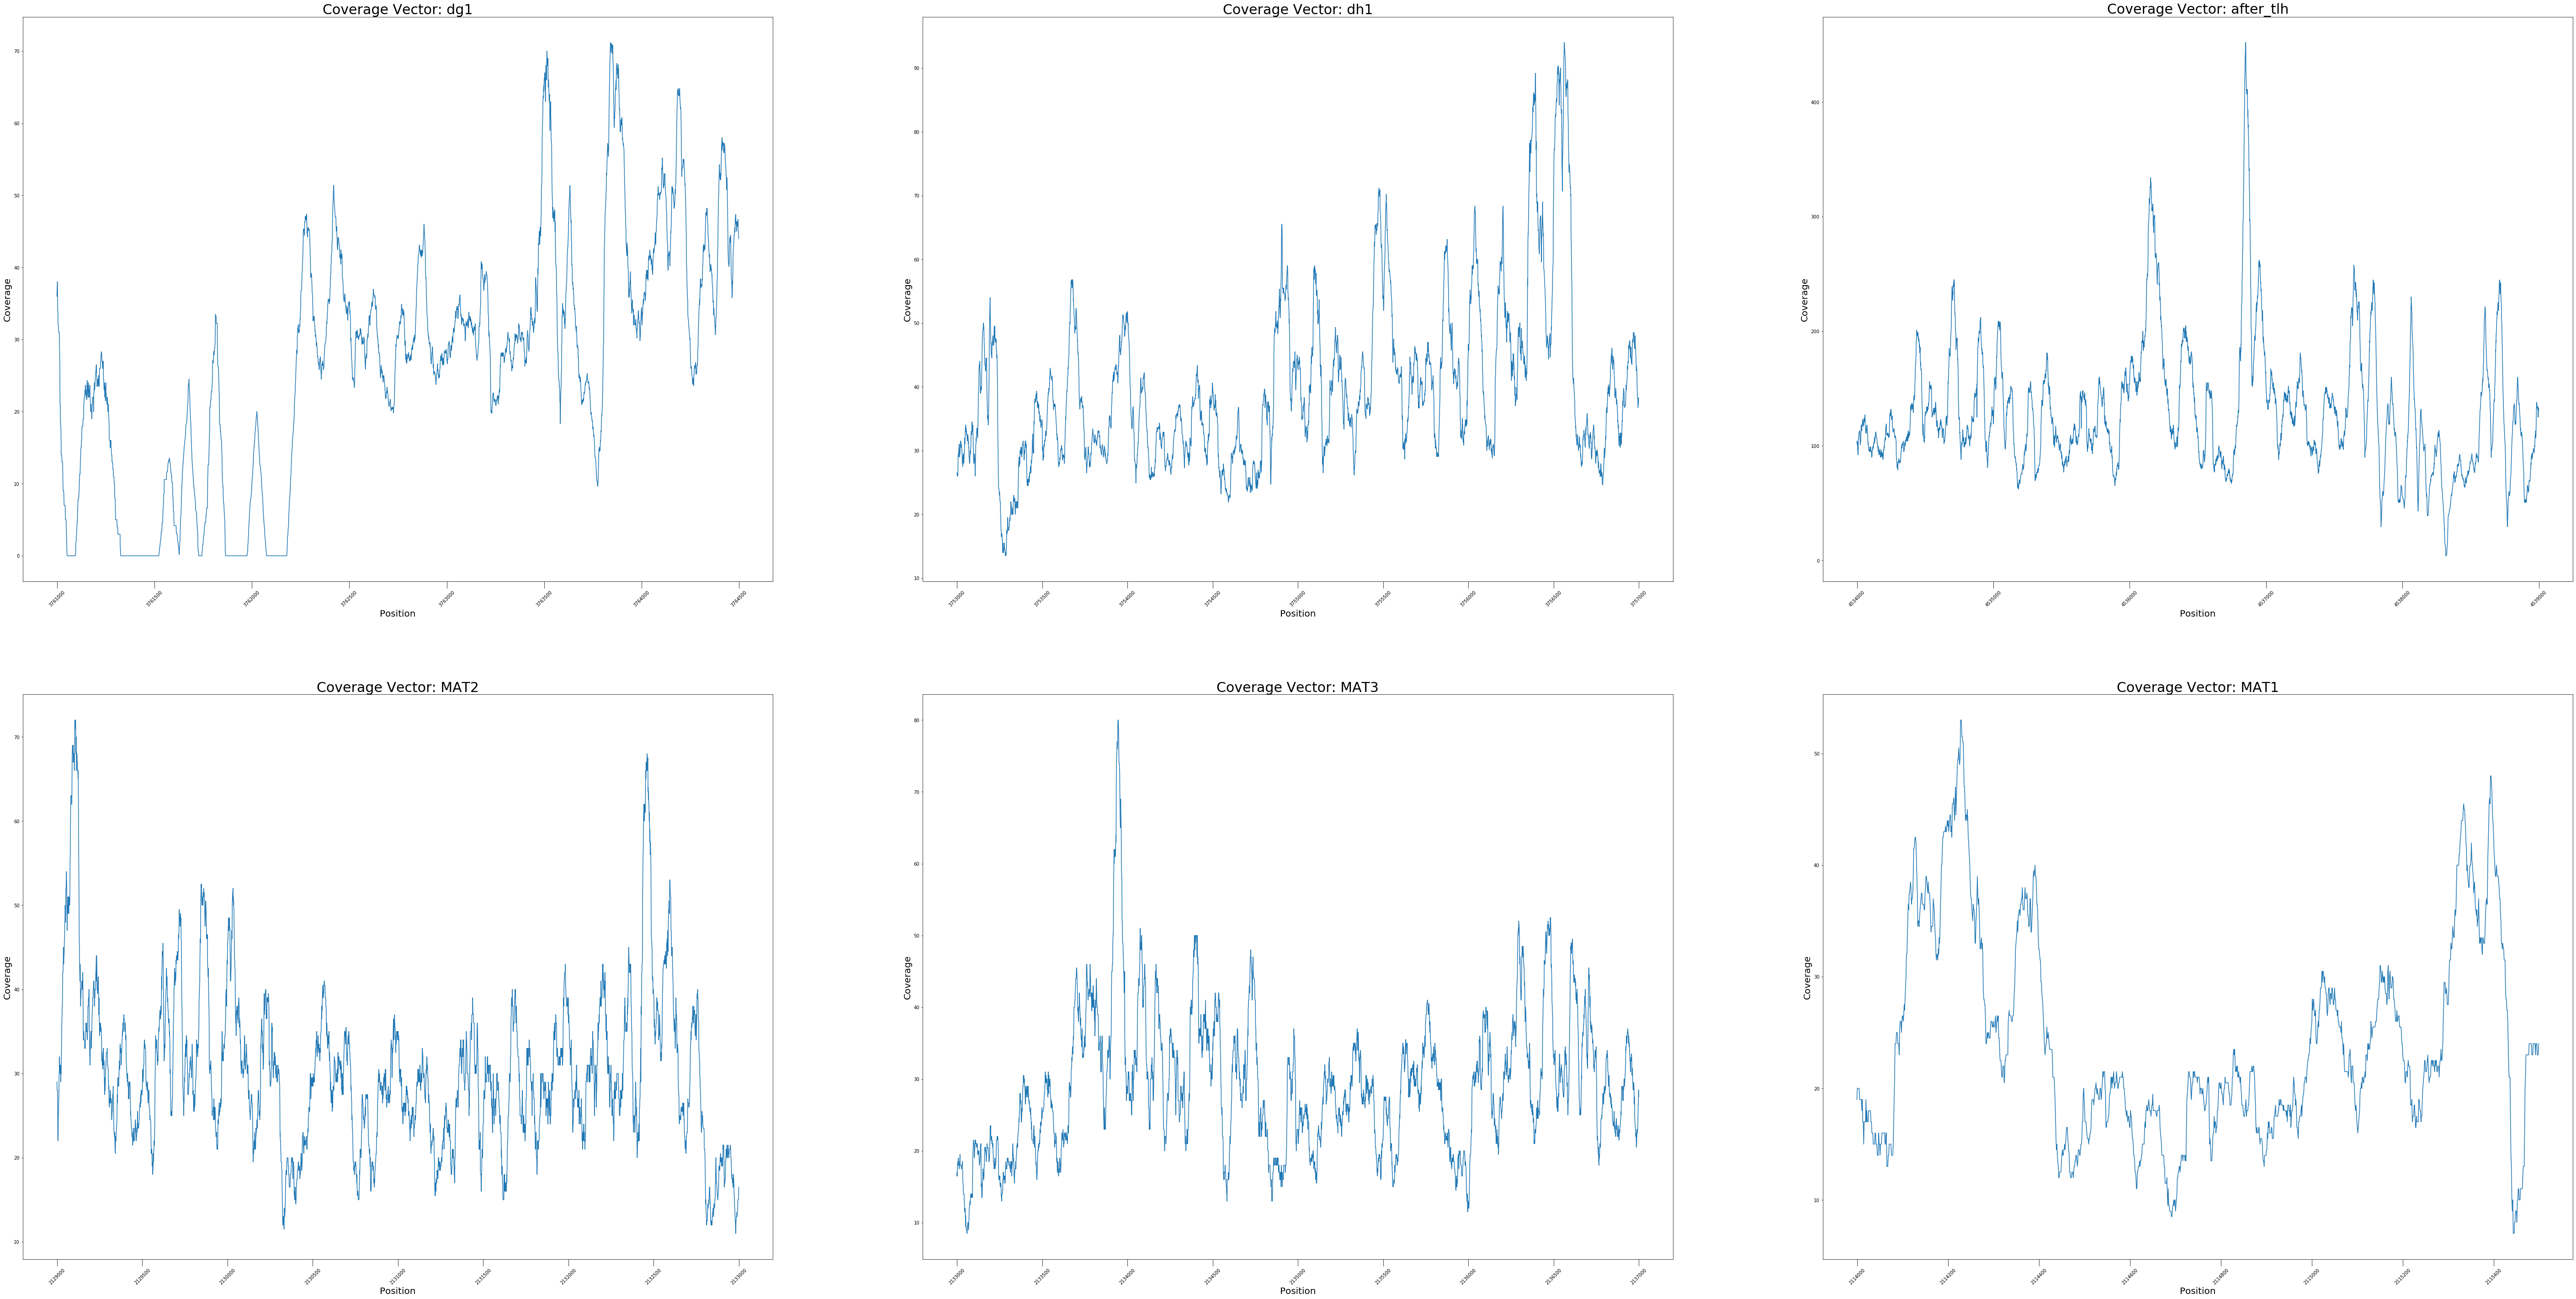

In [46]:
subplots_feature_coverage(fract_cvg, htc_genes_dict, n_rows=2, n_cols=3, fig_size=(100, 50), prefix= 'fract_', out_dir=out_dir)

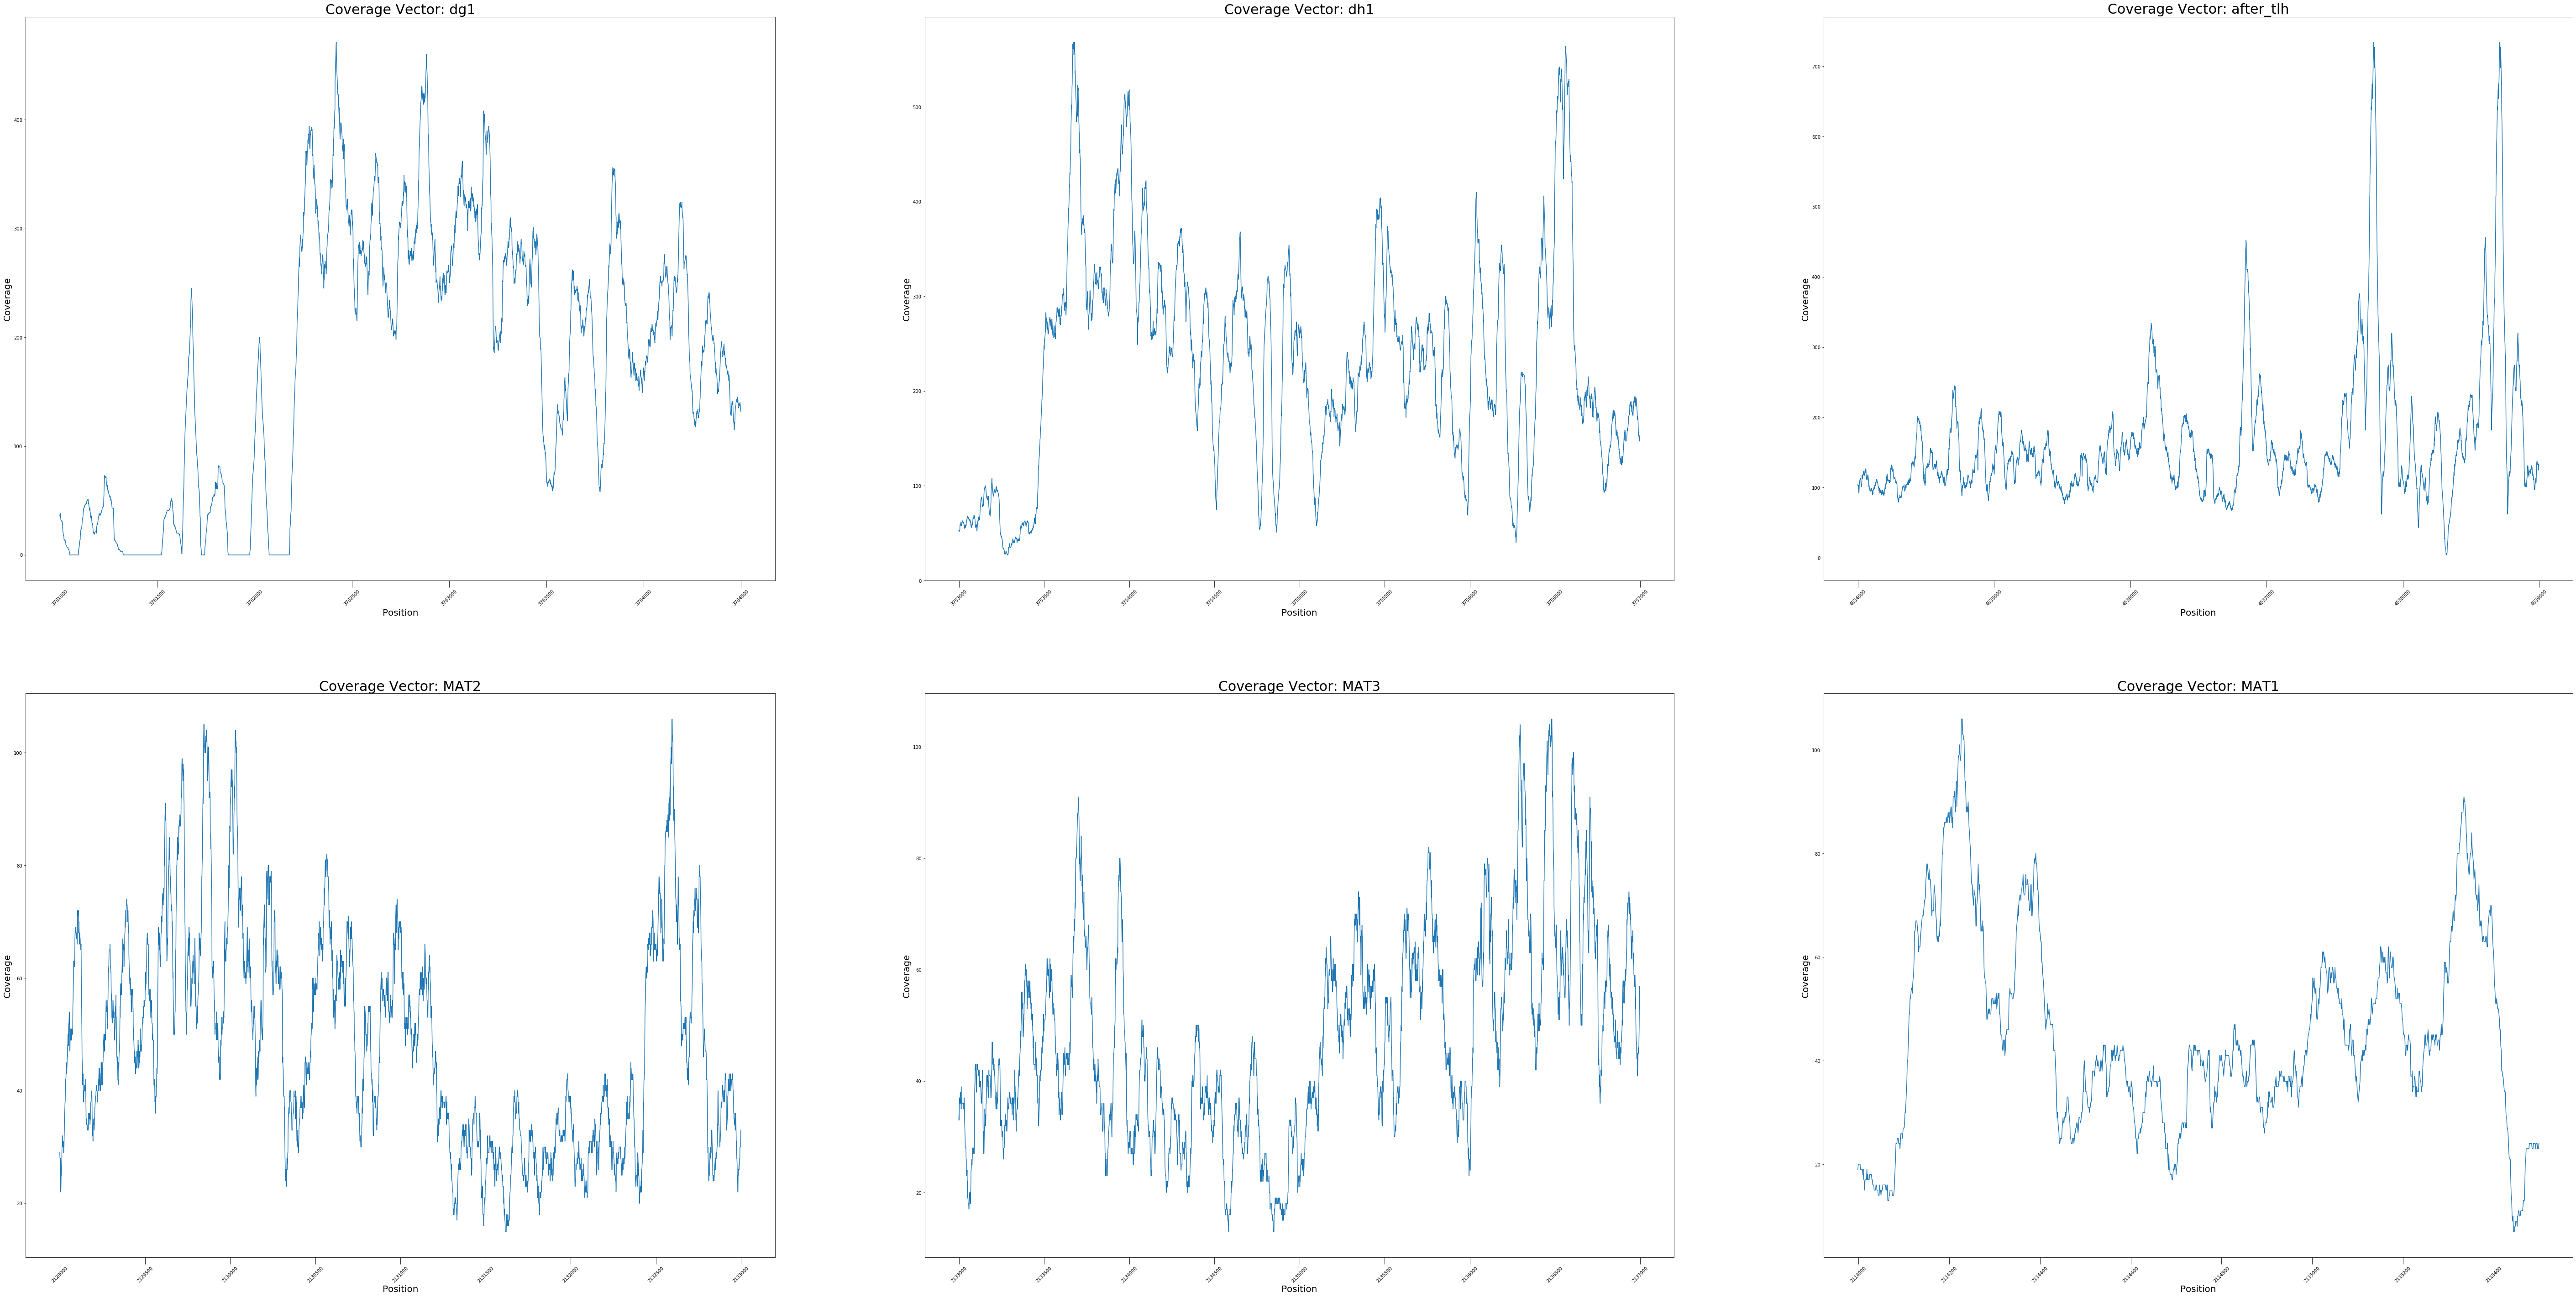

In [47]:
subplots_feature_coverage(int_cvg, htc_genes_dict, n_rows=2, n_cols=3, fig_size=(100, 50), prefix= 'int_', out_dir=out_dir)

However, a proper genome browser gives a better impression of the data. 

The following commands write two `BedGraph` (Wiggle) files, one for the **plus** and one for the **minus strands**:

In [48]:
if seq_type == 'ChIP':
    int_cvg.write_bedgraph_file(os.path.join(out_dir, "int.wig"), "." )
    fract_cvg.write_bedgraph_file(os.path.join(out_dir, "fractional.wig"), "." )
    
else:
    int_cvg.write_bedgraph_file(os.path.join(out_dir, "int_plus.wig"), "+" )
    fract_cvg.write_bedgraph_file(os.path.join(out_dir, "fractional_plus.wig"), "+" )

    int_cvg.write_bedgraph_file(os.path.join(out_dir, "int_minus.wig"), "-" )
    fract_cvg.write_bedgraph_file(os.path.join(out_dir, "fractional_minus.wig"), "-" )

These two files can then be viewed in a **genome browser** (e.g. [`IGB`](http://igb.bioviz.org/) or [`IGV`](http://www.broadinstitute.org/igv/)), alongside the annotation from a GFF file.

In [49]:
# Read name = 
# Read length = 50bp
# ----------------------
# Mapping = Primary @ MAPQ 3
# Reference span = II:2,133,153-2,133,202 (-) = 50bp
# Cigar = 50M
# Clipping = None
# ----------------------
# NH = 2
# HI = 1
# nM = 0
# AS = 49Location = II:2,133,171
# Base = A @ QV 38